## About

### Purpose
This notebook analyzes changes in the Biodiversity Intactness Index (BII) in the Phoenix subdivision between 2017 and 2020. The analysis examines the impact of urban expansion on biodiversity, focusing on areas where BII values declined during this period. Maricopa County experienced the largest increase in developed land among U.S. counties between 2001 and 2021, making this analysis critical for understanding urbanization's ecological impact.

### Highlights
- Accessing and processing raster data from the Microsoft Planetary Computer STAC catalog using `pystac_client` and `odc-stac`
- Calculating percentage of area meeting biodiversity thresholds (BII ≥ 0.75) using raster masking and pixel counting
- Identifying spatial patterns of biodiversity loss by comparing multi-temporal raster datasets
- Creating contextualized maps using `contextily` for basemaps and `geopandas` for vector overlay

### About the Data

**Biodiversity Intactness Index (BII) Time Series**  
The BII measures the average abundance of naturally occurring species relative to their abundance in undisturbed ecosystems. Values range from 0 to 1, with 1 representing intact biodiversity. This analysis uses BII rasters for 2017 and 2020 from the Microsoft Planetary Computer's io-biodiversity collection, covering the Phoenix subdivision area (bounding box: -112.826843, 32.974108, -111.184387, 33.863574).

**Phoenix Subdivision Shapefile**  
County subdivision boundary for Phoenix from the U.S. Census Bureau's TIGER/Line shapefiles, used to define the study area and clip raster data.

### References
1. Microsoft Planetary Computer. (n.d.). *io-biodiversity*. Retrieved from https://planetarycomputer.microsoft.com/dataset/io-biodiversity
2. U.S. Census Bureau. (n.d.). *TIGER/Line Shapefiles: County Subdivisions*. Retrieved from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

---

## Setup and Imports

In [1]:
# Load required libraries
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import pystac_client
import planetary_computer
from odc.stac import load as odc_load
import matplotlib.pyplot as plt
import contextily as ctx

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

### Load Phoenix Subdivision Boundary

In [2]:
# Load Phoenix subdivision shapefile
phoenix_gdf = gpd.read_file('data/tl_2020_04_cousub/tl_2020_04_cousub.shp')

# Filter for Phoenix subdivision only
phoenix_gdf = phoenix_gdf[phoenix_gdf['NAME'] == 'Phoenix'].copy()

# Check the current CRS and reproject to EPSG:4326 if needed for STAC queries
print(f"Original CRS: {phoenix_gdf.crs}")
phoenix_gdf_wgs84 = phoenix_gdf.to_crs('EPSG:4326')

# Display basic information
print(f"Phoenix subdivision geometry type: {phoenix_gdf_wgs84.geometry.type.values[0]}")
print(f"Bounds: {phoenix_gdf_wgs84.total_bounds}")

Original CRS: EPSG:4269
Phoenix subdivision geometry type: Polygon
Bounds: [-112.47015    33.29026  -111.580626   33.813966]


### Access BII Data from Microsfot Planetry Computer

In [3]:
# Define bounding box for Pheonix area
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Connect to Microsoft Planetary Computer STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace
)

# Search for BII data covering the Phoenix area
search = catalog.search(
    collections = ["io-biodiversity"],
    bbox = bbox
)

# Retrieve items
items = search.item_collection()
print(f"Found {len(items)} items in the io-biodiversity collection")

# Examine available items
for item in items:
    print(f"Item ID: {item.id}, Datetime: {item.datetime}\"")

Found 4 items in the io-biodiversity collection
Item ID: bii_2020_34.74464974521749_-115.38597824385106_cog, Datetime: None"
Item ID: bii_2019_34.74464974521749_-115.38597824385106_cog, Datetime: None"
Item ID: bii_2018_34.74464974521749_-115.38597824385106_cog, Datetime: None"
Item ID: bii_2017_34.74464974521749_-115.38597824385106_cog, Datetime: None"


In [4]:
# Filter items for 2017 and 2020
items_2017 = [item for item in items if '2017' in item.id]
items_2020 = [item for item in items if '2020' in item.id]

print(f"Found {len(items_2017)} items for 2017")
print(f"Found {len(items_2020)} items for 2020")

# Load 2017 and 2020 BII rasters using odc-stac
bii_2017 = odc_load(
    items_2017,
    bbox = bbox,
    chunks = {}
) 

bii_2020 = odc_load(
    items_2020,
    bbox = bbox,
    chunks = {}
)

# Check data structure
print("\n2017 BII data:")
print(bii_2017)
print("\n2020 BII data:")
print(bii_2020)

Found 1 items for 2017
Found 1 items for 2020

2017 BII data:
<xarray.Dataset> Size: 7MB
Dimensions:      (latitude: 991, longitude: 1830, time: 1)
Coordinates:
  * latitude     (latitude) float64 8kB 33.86 33.86 33.86 ... 32.98 32.98 32.97
  * longitude    (longitude) float64 15kB -112.8 -112.8 -112.8 ... -111.2 -111.2
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2017-01-01
Data variables:
    data         (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 991, 1830), meta=np.ndarray>

2020 BII data:
<xarray.Dataset> Size: 7MB
Dimensions:      (latitude: 991, longitude: 1830, time: 1)
Coordinates:
  * latitude     (latitude) float64 8kB 33.86 33.86 33.86 ... 32.98 32.98 32.97
  * longitude    (longitude) float64 15kB -112.8 -112.8 -112.8 ... -111.2 -111.2
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2020-01-01
Data variables:
    data         (time, latitude, longitude) float32 7MB dask.array<chunksize=(1, 991, 1830

## Data Exploration

Examine the BII raster properties and value distributions to understand the data before analysis.

In [5]:
# Explore BII data structure and values
# Check CRS
print(f"2017 CRS: {bii_2017.rio.crs}")
print(f"2020 CRS: {bii_2020.rio.crs}")

# Check resolution
print(f"\n2017 resolution: {bii_2017.rio.resolution()}")
print(f"2020 resolution: {bii_2020.rio.resolution()}")

# Check data variables and select the BII band
print(f"\n2017 data variables: {list(bii_2017.data_vars)}")
print(f"2020 data variables: {list(bii_2020.data_vars)}")

2017 CRS: EPSG:4326
2020 CRS: EPSG:4326

2017 resolution: (0.0008983152841195215, -0.0008983152841195215)
2020 resolution: (0.0008983152841195215, -0.0008983152841195215)

2017 data variables: ['data']
2020 data variables: ['data']


In [6]:
# Extract the BII band
bii_2017_band = bii_2017["data"]
bii_2020_band = bii_2020["data"]

# Check value ranges
print(f"\n2017 BII range: {bii_2017_band.min().values} to {bii_2017_band.max().values}")
print(f"2020 BII range: {bii_2020_band.min().values} to {bii_2020_band.max().values}")

# Check for NoData values
print(f"\n2017 NoData value: {bii_2017_band.rio.nodata}")
print(f"2020 NoData value: {bii_2020_band.rio.nodata}")


2017 BII range: 0.07058961689472198 to 0.9353436827659607
2020 BII range: 0.08015034347772598 to 0.9353436827659607

2017 NoData value: None
2020 NoData value: None


## Geographic Context Map

Create a map showing the Phoenix subdivision within its broader geographic context.

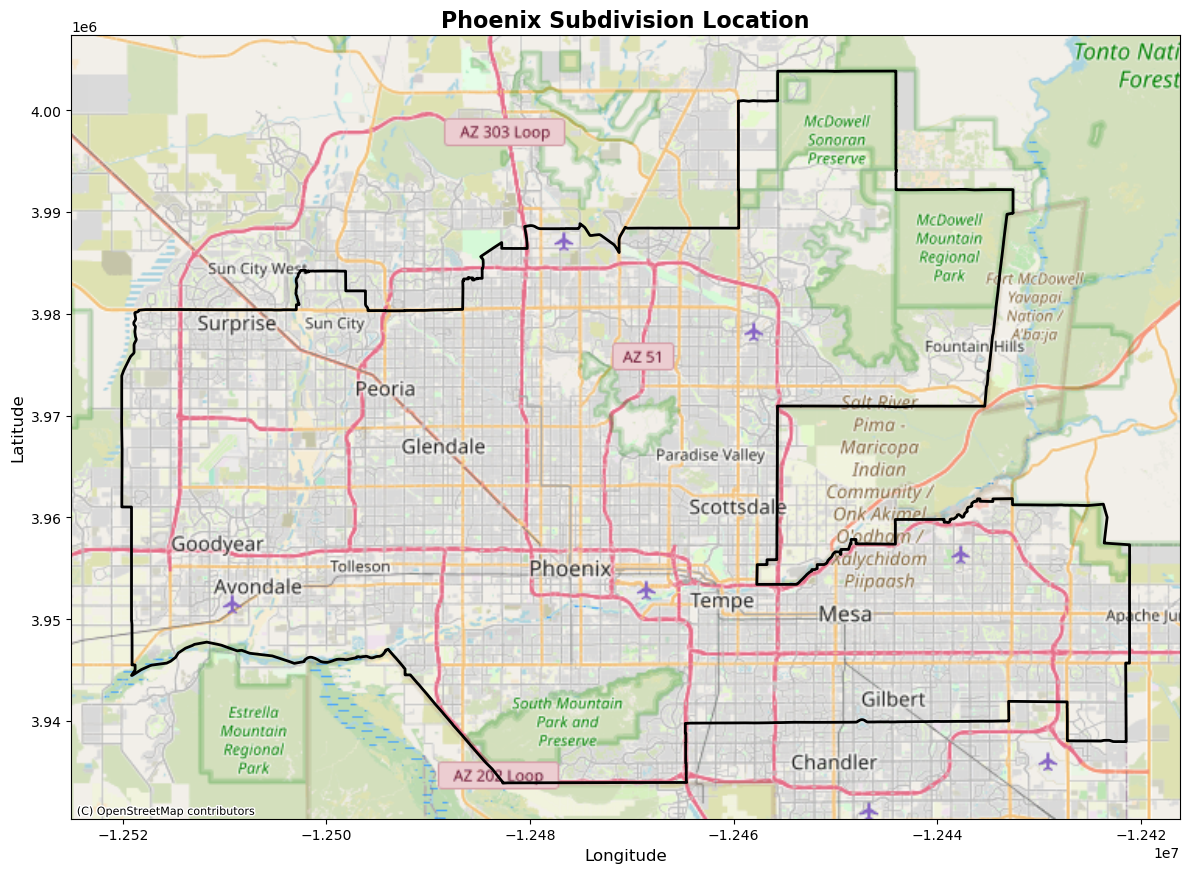

In [7]:
# Reproject Phoenix boundary to Web Mercator for contextily basemap
phoenix_merc = phoenix_gdf_wgs84.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(12, 10))

# Plot Phoenix subdivision
phoenix_merc.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='Phoenix Subdivision')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Formatting
ax.set_title('Phoenix Subdivision Location', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
#ax.legend()

plt.tight_layout()
plt.show()

## BII Analysis

### Calculate Percentage of Area with BII $\geq$ 0.75

First we reproject and clip the BII rasters using the Pheonix subdivision boundary

In [10]:
# Reproject Phoenix boundary to match BII raster CRS
phoenix_raster_crs = phoenix_gdf.to_crs(bii_2017.rio.crs)

# Clip rasters to Phoenix boundary
bii_2017_clipped = bii_2017_band.rio.clip(phoenix_raster_crs.geometry, phoenix_raster_crs.crs, drop=True)
bii_2020_clipped = bii_2020_band.rio.clip(phoenix_raster_crs.geometry, phoenix_raster_crs.crs, drop=True)

print(f"2017 clipped shape: {bii_2017_clipped.shape}")
print(f"2020 clipped shape: {bii_2020_clipped.shape}")


2017 clipped shape: (1, 583, 990)
2020 clipped shape: (1, 583, 990)


Now we can calculate the percentage of pixels with BII $\geq$ 0.75

In [11]:
# Create mask for BII >= 0.75
mask_2017_high = bii_2017_clipped >= 0.75
mask_2020_high = bii_2020_clipped >= 0.75

# Count pixels meeting threshold
count_2017_high = mask_2017_high.sum().values
count_2020_high = mask_2020_high.sum().values

# Create mask for valid data
valid_2017 = ~np.isnan(bii_2017_clipped.values)
valid_2020 = ~np.isnan(bii_2020_clipped.values)

# Count total valid pixels
count_2017_total = valid_2017.sum()
count_2020_total = valid_2020.sum()

# Calculate percentage 
pct_2017 = (count_2017_high / count_2017_total) * 100
pct_2020 = (count_2020_high / count_2020_total) * 100

print(f"Percentage of Phoenix area with BII ≥ 0.75 in 2017: {pct_2017:.2f}%")
print(f"Percentage of Phoenix area with BII ≥ 0.75 in 2020: {pct_2020:.2f}%")
print(f"Change: {pct_2020 - pct_2017:.2f} percentage points")

Percentage of Phoenix area with BII ≥ 0.75 in 2017: 7.11%
Percentage of Phoenix area with BII ≥ 0.75 in 2020: 6.48%
Change: -0.63 percentage points


### Visualize Areas of BII Loss

Create a map showing areas where BII $\geq$ 0.75 in 2017 but fell below this threshold by 2020. First we identify areas that lost high BII status.

loss_areas shape: (583, 990)
Pixels with BII loss: 2172


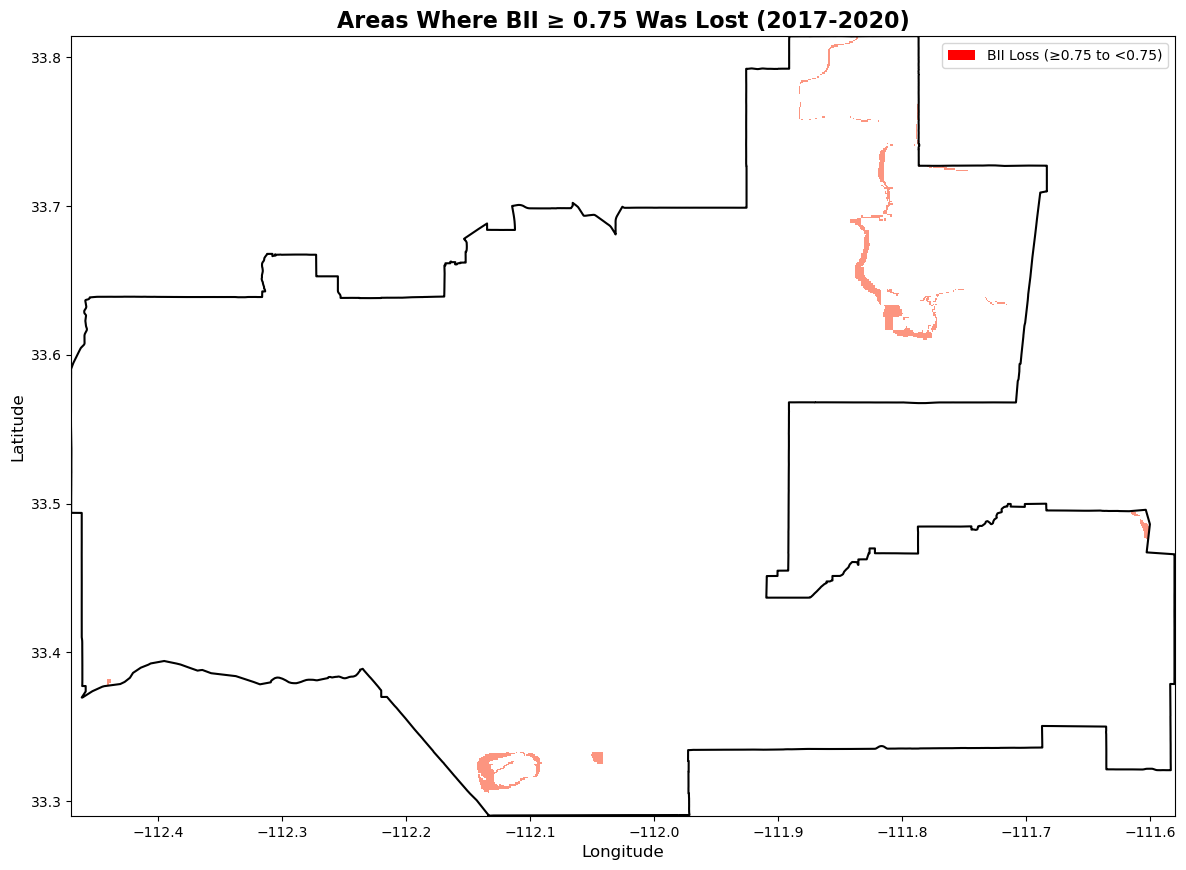


Percentage of Phoenix area that lost high BII status: 0.64%
Number of pixels that lost high BII status: 2172


In [20]:
# High BII 2017 mask
high_2017 = mask_2017_high

# Low BII 2020 mask
low_2020 = bii_2020_clipped < 0.75

# Remove the time dimension since we only have one time per dataset
high_2017_squeeze = high_2017.squeeze()
low_2020_squeeze = low_2020.squeeze()

# BII loss mask
loss_areas = high_2017_squeeze & low_2020_squeeze

# Create a copy for visualization and set loss areas = 1, others = NaN
loss_viz = loss_areas.astype(float).where(loss_areas, np.nan)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the loss areas
loss_viz.plot(
    ax=ax,
    cmap='Reds',
    add_colorbar=False,
    alpha=0.7
)

# Add Phoenix boundary outline
phoenix_raster_crs.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)

# Formatting
ax.set_title('Areas Where BII ≥ 0.75 Was Lost (2017-2020)', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=1, label='BII Loss (≥0.75 to <0.75)')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Calculate area of loss
loss_pixel_count = loss_areas.sum().values
loss_percentage = (loss_pixel_count / count_2017_total) * 100
print(f"\nPercentage of Phoenix area that lost high BII status: {loss_percentage:.2f}%")
print(f"Number of pixels that lost high BII status: {loss_pixel_count}")

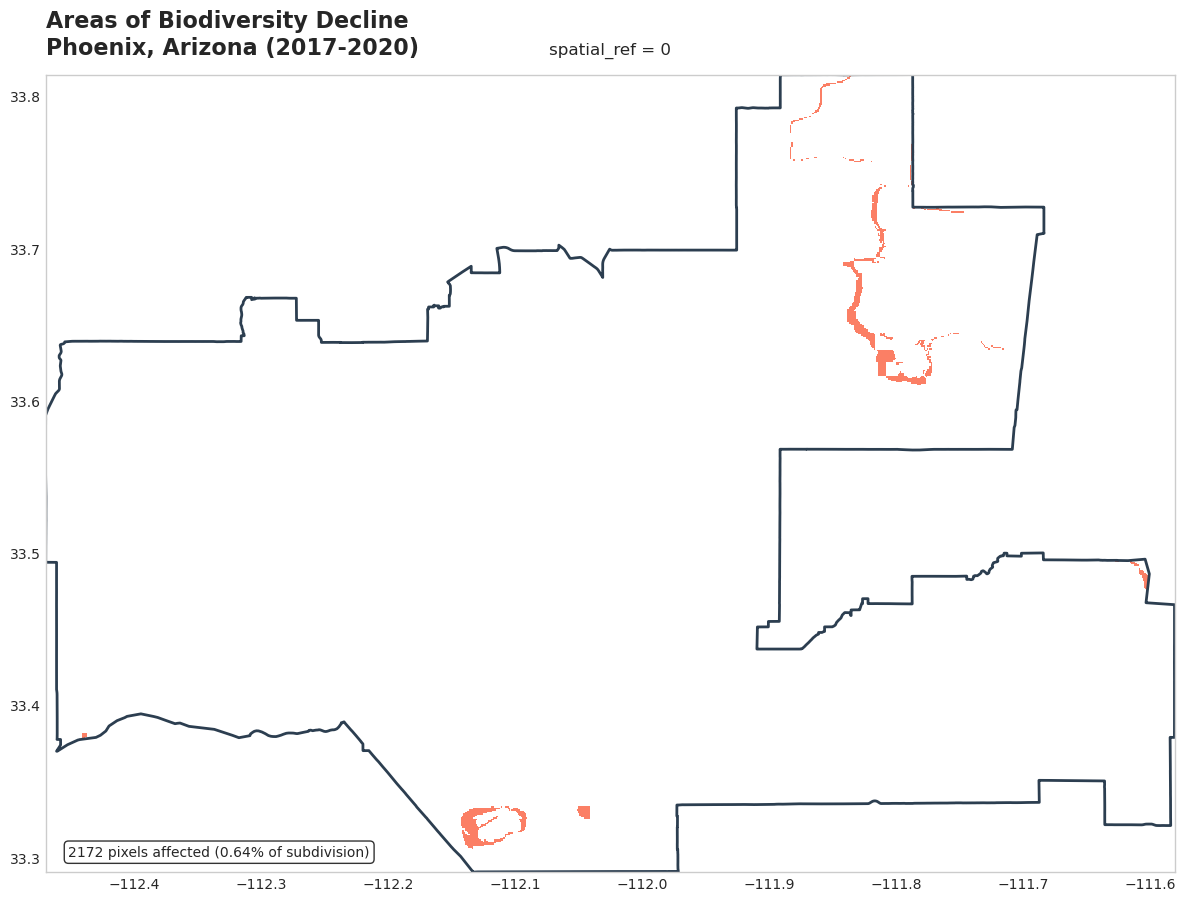

In [21]:
# Minimal, clean style
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')  # Or try 'seaborn-v0_8-darkgrid', 'bmh', 'ggplot'

fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

# Plot loss areas
loss_viz.plot(
    ax=ax,
    cmap='Reds',
    add_colorbar=False,
    alpha=0.85
)

# Boundary
phoenix_raster_crs.plot(
    ax=ax,
    facecolor='none',
    edgecolor='#2c3e50',  # Dark blue-gray
    linewidth=2
)

# Clean title
ax.set_title(
    'Areas of Biodiversity Decline\nPhoenix, Arizona (2017-2020)',
    fontsize=16,
    fontweight='bold',
    loc='left',
    pad=15
)

# Remove axis labels for cleaner look
ax.set_xlabel('')
ax.set_ylabel('')

# Add scale bar text
ax.text(
    0.02, 0.02,
    f'{loss_pixel_count} pixels affected (0.64% of subdivision)',
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()